# Tutorial on OQMD 
### (Nove 23, 2021)


## Part 1: Querying OQMD and Retrieving data using OPTIMADE

In [1]:
# Import libraries

import requests
from copy import deepcopy
import os
import shutil
import json
from pathlib import Path

In [2]:
# Set the base URL for OPTIMADE REST queries

rest_base = "http://oqmd.org/optimade/structures?"

In [3]:
# Create the query URL with filter, response_fields and paging requirements

# The following query filters for data of ternary non-metallic oxides
# Crystal structure parameters and Band gap values are returned in response_fields
# Crystal structures will be used to generate representational vectors (input features) for ML
# Bandgap values will be used as targets for ML


filter_   = 'stability<=0 AND elements HAS "O" AND nelements=3 AND _oqmd_band_gap>0'
response_ = 'id,_oqmd_entry_id,lattice_vectors,cartesian_site_positions,species_at_sites,_oqmd_band_gap'
page_     = ["page_offset=0", 
             "page_limit=200"]

filter_   = 'filter=' + filter_
response_ = 'response_fields=' + response_
oqmd_optimade_query = rest_base + "&".join([filter_, response_]+page_)
print("Created Query: \n\n{}".format(oqmd_optimade_query))

Created Query: 

http://oqmd.org/optimade/structures?filter=stability<=0 AND elements HAS "O" AND nelements=3 AND _oqmd_band_gap>0&response_fields=id,_oqmd_entry_id,lattice_vectors,cartesian_site_positions,species_at_sites,_oqmd_band_gap&page_offset=0&page_limit=200


In [4]:
# Now do a test query on URL using requests.get() This can take a few minutes

response = requests.get(oqmd_optimade_query)
if response.status_code == 200:
    print("Success!")
    #print(response.json())
else:
    print("Query failed. Status: {}".format(response.status_code))
    print("Error Message: {}".format(response.text))

Success!


In [5]:
# We need more than 200 datapoints for machine learning - if more data is available

# As the first step, here's the same script from the cell above, but kept inside a function 

def query_oqmd_optimade(query):
    print("\nQuerying: {}".format(query))
    response = requests.get(query)
    if response.status_code == 200:
        print("Success!")
        return response.json()
    else:
        print("Query failed. Status: {}".format(response.status_code))
        print("Error Message: {}".format(response.text))
        return 
    
    

# Next, we query for 1000 materials in total using 5 sequential API queries - each paginated to
# retrieve 200 materials


load_data_from_saved = True  
# This is to avoid querying OQMD repeatedly for the same data, if .
# Because the data I downloaded is already available as a JSON file in this Git repo.

# But if you'd like to try out querying OQMD, set "load_data_from_saved" as "False"
# Querying OQMD for this particular data would take about 5-10 minutes to complete


dataset_filename = Path(os.path.realpath(".")).joinpath("./oqmd_exercise_data/raw_dataset_saved.json")
# Check if the file exists: on Colab for example, you do not have access to the local directory
if not os.path.isfile(dataset_filename):
    load_data_from_saved = False

if load_data_from_saved:
    with open(dataset_filename, 'r') as fin:
        dataset = json.load(fin)
else:
    dataset = []
    query = oqmd_optimade_query
    for i in range(5):
        jsondata = query_oqmd_optimade(query)
        if jsondata is None:
            break
        else:
            # Get the link to the next page and query it in next loop iteration
            query = deepcopy(jsondata['links']['next'])
            dataset.append(deepcopy(jsondata))
    with open(dataset_filename, 'w') as fout:
        json.dump(dataset, fout)


In [6]:
# Confirm the paginated response - checking reliability of server-side and client side scripts

for i in range(len(dataset)):
    query = dataset[i]['meta']['query']['representation']
    page_params =  [param for param in query.split("&") if param.startswith("page")]
    print("{}:{}".format(i,", ".join(page_params)))
    #print(dataset[i]['meta']['query']['_oqmd_final_query'])

0:page_offset=0, page_limit=200
1:page_limit=200, page_offset=200
2:page_limit=200, page_offset=400
3:page_limit=200, page_offset=600
4:page_limit=200, page_offset=800


In [7]:
# Inspect the response data keys and confirm all the necessary information is available

print(dataset[0]['data'][0].keys())
print(dataset[0]['data'][0]['attributes'].keys())
print(dataset[0]['meta'].keys())

dict_keys(['id', 'type', 'attributes'])
dict_keys(['lattice_vectors', 'species_at_sites', 'cartesian_site_positions', '_oqmd_entry_id', '_oqmd_band_gap'])
dict_keys(['query', 'api_version', 'time_stamp', '_oqmd_data_in_response', 'data_returned', 'data_available', 'more_data_available', 'provider', 'warnings', 'response_message'])


In [8]:
# As you can see, the type of the returned data is OPTIMADE's "structures"
print(dataset[0]['data'][1]['type'])

structures


In [9]:
# Here's a function to convert OPTIMADE's structure data to POSCAR. 

# Make sure that 'lattice_vectors', 'species_at_sites', and 'cartesian_site_positions' are
# included in the response_fields of query URL

def get_poscar_from_optimade_structure(structure):
    if '_oqmd_entry_id' in structure['attributes'].keys():
        poscar =  ["REST API StructureID {}, OQMD Entry ID {}".format(
            structure['id'], structure['attributes']['_oqmd_entry_id']
        )]
        filename = "ID-{}_OQMD-EnID-{}.poscar".format(structure['id'],structure['attributes']['_oqmd_entry_id'])
    else:
        poscar =  ["REST API StructureID {}".format(structure['id'])]
        filename = "ID-{}.poscar".format(structure['id'])
        
    poscar.append("1.0")
    
    poscar += [" ".join([str(jtem) for jtem in item]) 
               for item in structure['attributes']['lattice_vectors']
              ]
    
    elems  = []
    counts = []
    for item in structure['attributes']['species_at_sites']:
        if item in elems:
            assert elems.index(item) == len(elems)-1
            counts[-1] += 1
        else:
            elems.append(deepcopy(item))
            counts.append(1)
    poscar.append(" ".join(elems))
    poscar.append(" ".join([str(item) for item in counts]))
    
    poscar.append("Cartesian")
    
    poscar += [" ".join([str(jtem) for jtem in item]) 
               for item in structure['attributes']['cartesian_site_positions']
              ]
    poscar = "\n".join(poscar)
    return (poscar, filename)

In [10]:
# Call the OPTIMADE structure -> POSCAR conversion function 
# and save all structures in directory "./input_poscars"

# Also save the bandgap values in a file "target_properties.csv"

poscar_dir = "./input_poscars"
if os.path.exists(poscar_dir):
    shutil.rmtree(poscar_dir)
os.mkdir(poscar_dir)

properties = []

for dt in dataset:
    for st in dt['data']:
        poscar, filename = get_poscar_from_optimade_structure(deepcopy(st))
        target_value = deepcopy(st['attributes']['_oqmd_band_gap'])
        properties.append(",".join([filename,str(target_value)]))
        with open(os.path.join(poscar_dir,filename),"w") as fout:
            fout.write(poscar)
with open("target_properties.csv","w") as fout:
    fout.write("filename, _oqmd_band_gap \n")
    fout.write("\n".join(properties))

## Part 2: Feature Generation

### We need to generate a set of material representation vectors (input features) from the POSCAR data for Machine Learning

#### The set of features generated for this tutorial is given in the file  "features_processed_final.csv" in the Github repo


### Optional
#### An example set of steps to generate Magpie material features is shown below. The following commands are to be executed on a bash shell from the same directory where this jupyter notebook resides. 

$ git clone git@github.com:tachyontraveler/magpie_workflow.git

> Cloning into 'magpie_workflow'...
>
> remote: Enumerating objects: 115, done.
>
> remote: Counting objects: 100% (6/6), done.
>
> remote: Compressing objects: 100% (6/6), done.
>
> remote: Total 115 (delta 2), reused 0 (delta 0), pack-reused 109
>
> Receiving objects: 100% (115/115), 16.03 MiB | 3.25 MiB/s, done.
>
> Resolving deltas: 100% (31/31), done.


$ cp -r ./input_poscars magpie_workflow/

$ cd magpie_workflow

$ python3 workflow.py 

>Initializing the workflow class
>
> 2021-11-22 19:51:45.614116 ::  Generating property.txt file
>
> 2021-11-22 19:51:45.616918 ::  Generating Magpie input commands file 
>
> 2021-11-22 19:51:45.617025 ::  Magpie input file created as ./OUTDIR/generate-attributes.in
>
> 2021-11-22 19:51:45.617060 ::  Calling Magpie with the input script.. 
>
>2021-11-22 19:51:45.617102 ::  May check out.workflow.txt for Magpie messages
>
>2021-11-22 19:52:36.347243 ::  Finished Magpie generation. Now post-processing
>
>2021-11-22 19:52:36.399678 ::  Done

$ cd ../

$ cp magpie_workflow/OUTDIR/features_processed_final.csv ./


## Part 3: Machine Learning

#### Now we can proceed to build a small ML model using Scikit Learn library modules and fit it on the data obtained above

In [11]:
# Import the required libraries

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt 

In [12]:
# Load the data generated in previous sections

# Input feature data - generated using Magpie on POSCAR files
if os.path.isfile("./features_processed_final.csv"): # Case where the optional part has been done
    features = open("./features_processed_final.csv","r").read().strip().split("\n")
else: 
    features = open("./oqmd_exercise_data/features_processed_final.csv","r").read().strip().split("\n") # When the optional part was not done
feats_title = features[0].strip().split(",")

features = np.array([item.strip().split(",") for item in features[1:]])
features = features[~np.isnan(features[:,1:].astype(float)).any(axis=1)]
I = features[:,0]
X = features[:,1:].astype(float)


# Target data (bandgap values)
targets = open("./target_properties.csv").read().strip().split("\n")
targets_title = targets[0].strip().split(",")

targets = np.array([item.strip().split(",") for item in targets[1:]])
targets = dict(zip(targets[:,0],targets[:,1].astype(float)))

Y = [targets[item] for item in I]

# The feats_title and targets_title are not used anywhere else in this tutorial. 
# But I'd recommend keeping them for tracking features and targets in an actual ML study
# For example, they can be be useful in feature importance analysis or in multi-target modelling

In [13]:
# Split the data to train and test sets

xtrain, xtest, ytrain, ytest = train_test_split(X, Y, 
                                                test_size=0.2,
                                                random_state=0)

In [14]:
# Create a Scikit Learn pipeline with feature scaling, dimension reduction, and fianlly, a regressor

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('svr', SVR())
])

# Parameters to search in finding the best model
# The following sets of parameters are just for a shallow search for optimization
# A finer search for parameters will be required on an actual ML study

params = {
    'pca__n_components': [200,250,xtrain.shape[-1]],
    'svr__C':[0.1,1,10,20],
    'svr__kernel':['rbf'],
    'svr__epsilon':[0.1],
    'svr__gamma':['scale']
}

gridsearch = GridSearchCV(pipeline, params, cv=3)

In [15]:
# Do the grid search and get scores

gridsearch.fit(xtrain, ytrain)

print('Traindata score: {}'.format(gridsearch.score(xtrain, ytrain)))
print('Testdata score: {}'.format(gridsearch.score(xtest, ytest)))

Traindata score: 0.9784009665385435
Testdata score: 0.777335409156177


#### (I'm aware that the test data score is much lower that of traindata - implying a possible overfit.  But this would work just fine as a representational ML modeling workflow for this tutorial session.)

In [16]:
# See which set of paramters had the best fit as of now
print(gridsearch.best_estimator_)

# Further, a finer search for most optimum set of paramters is required to get a better model.
# But for the sake of this tutorial, I'm gonna continue to plot the testdata predictions

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=200)),
                ('svr', SVR(C=10))])


In [17]:
# Get predictions on test data

ytest_pred = gridsearch.predict(xtest)

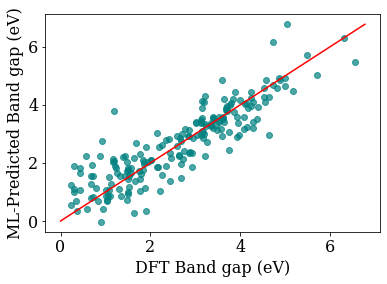

In [18]:
# Plot the predictions

plt.rcParams['font.size'] = 16
plt.rcParams["font.family"] = "serif"

plt.scatter(ytest, ytest_pred, 
            color='teal', 
            alpha=0.7)
plt.xlabel("DFT Band gap (eV)")
plt.ylabel("ML-Predicted Band gap (eV)")
xmax = max([max(ytest),max(ytest_pred)])
plt.plot([0,xmax],[0,xmax],color='red')

plt.show()

In [19]:
# Close the plots
plt.close()

### That's it for now, folks!
I hope this notebook helped to get started on retrieving OQMD data via OPTIMADE API and using it to build a quick ML model.

I will try to add more descriptive information and enhancements to this tutorial in the future.

Let me know if you have any questions!